In [162]:
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls

/content
Cloning into 'Gradu'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 355 (delta 82), reused 43 (delta 43), pack-reused 232 (from 2)
Receiving objects: 100% (355/355), 51.89 MiB | 30.28 MiB/s, done.
Resolving deltas: 100% (163/163), done.
/content/Gradu
 chatti_RF.ipynb	       Gradient_boost_malli.ipynb	    regime_pred.txt
 data+regimes.xlsx	       MSCI_XGBOOST.ipynb		    RF_Gradu.ipynb
 Fama_french_XGBOOST.ipynb     Regiimi_prediction.ipynb		   'RF REGIIMI HYVÄ TRAINING.ipynb'
'Financial turbulence.ipynb'   regime_prediction_famafrench.ipynb  'RF_regime (3).ipynb'
 FT_source.xlsx		       regime_prediction_msci.ipynb	    THE_ONE.xlsx


In [163]:
calc_drawdowns = True
drawdowns_from = 'Mkt-RF'
cluster_n = 3

DL = False
ML_new = True
ML_old = False

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML
from sklearn.cluster import KMeans

In [165]:
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
excel_df = xls_file.parse("22.2.2025")

excel_df.columns = excel_df.columns.get_level_values(0)
excel_df['Date'] = pd.to_datetime(excel_df['Date'])
excel_df.sort_values('Date', inplace=True)

print("Headers in the 'returns non-log' sheet:")
print(excel_df.columns)

Headers in the 'returns non-log' sheet:
Index(['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'SMB-12A',
       'HML-12A', 'RMW-12A', 'CMA-12A', 'RSI-SMB', 'RSI-HML', 'RSI-RMW',
       'RSI-CMA', 'CPI', 'Cape', 'Treasury_10Y', 'Winning Factor', 'check',
       'NFCI', 'T10YFF', 'DGS1', 'DGS5', 'GARCH', 'Last_month', 'Amihud'],
      dtype='object')


In [166]:
# 1) Load the Excel file and parse the "FF5" sheet
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
df = xls_file.parse("FF5", decimal=",")

# 2) Convert 'Date' column to DateTime format (assuming 'day.month.year')
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')

# Convert columns to numeric and scale by 100 (if percentages, e.g., 0.79 means 0.79%)
for col in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']:
    df[col] = pd.to_numeric(df[col], errors='coerce') / 100.0

# Drop rows where Date is missing
df.dropna(subset=['Date'], inplace=True)

# 3) Sort by Date
df.sort_values(by='Date', inplace=True)

# 4) Calculate the daily total market return:
#    Total_Mkt_Return = Mkt-RF + RF
df['Total_Mkt_Return'] = df['Mkt-RF'] + df['RF']

# 5) Compute cumulative returns and drawdowns:
#    Cumulative return = cumulative product of (1 + daily return)
#    Drawdown = current cumulative value / max cumulative so far - 1
df['Cumulative'] = (1 + df['Total_Mkt_Return']).cumprod()
df['Drawdown'] = df['Cumulative'] / df['Cumulative'].cummax() - 1

# Set Date as the index for easier slicing
df.set_index('Date', inplace=True)

# 6) Create a complete series of month‐start dates over the period
start_date = df.index.min().replace(day=1)
end_date = df.index.max().replace(day=1)
monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS')  # 'MS' = Month Start

results = []
for current_date in monthly_dates:
    # Define the 3-month look-back window (excluding the day exactly 3 months ago)
    window_start = current_date - pd.DateOffset(months=3)
    # Slice data in the window: > window_start and <= current_date
    window_data = df.loc[(df.index > window_start) & (df.index <= current_date)]

    if not window_data.empty:
        # Maximum drawdown in the window (the most negative drawdown)
        max_drawdown = window_data['Drawdown'].min()
        results.append((current_date, max_drawdown))
    else:
        results.append((current_date, np.nan))

# Store the results in a temporary DataFrame as before
dd_temp = pd.DataFrame(results, columns=['Date', '3M_Max_Drawdown'])

# Drop rows with missing drawdown data to ensure complete observations
dd_temp.dropna(inplace=True)

print("Drawdown calculation (temporary DataFrame):")
print(dd_temp.head())

# Optionally, set Date as the index:
# dd_temp.set_index('Date', inplace=True)


Drawdown calculation (temporary DataFrame):
        Date  3M_Max_Drawdown
0 1963-07-01         0.000000
1 1963-08-01        -0.029629
2 1963-09-01        -0.029629
3 1963-10-01        -0.029629
4 1963-11-01        -0.022195


In [167]:
# if calc_drawdowns:
#     # Calculate the cumulative portfolio values using excel_df and the specified drawdowns_from column
#     portfolio = (1 + excel_df[drawdowns_from]).cumprod()

#     # Define a function to compute the maximum drawdown over a rolling window
#     def max_dd(s):
#         return (s / s.cummax() - 1).min()

#     # Calculate the 3-month rolling drawdown using the portfolio series
#     dd_series = portfolio.rolling(window=3, min_periods=3).apply(max_dd, raw=False)

#     # Create a temporary DataFrame to store dates and the calculated drawdowns
#     dd_temp = pd.DataFrame({
#         'Date': excel_df['Date'],
#         '3M_Max_Drawdown': dd_series
#     })

#     # Drop rows with missing drawdown data to ensure complete observations
#     dd_temp = dd_temp.dropna()

#     print("Drawdown calculation (temporary DataFrame):")
#     print(dd_temp.head())


In [168]:
# Fit KMeans clustering on the temporary DataFrame's '3M_Max_Drawdown' column
kmeans = KMeans(n_clusters=cluster_n, random_state=42)
dd_temp['DD_cluster'] = kmeans.fit_predict(dd_temp[['3M_Max_Drawdown']])

# Merge the cluster labels from dd_temp into excel_df by matching on the 'Date' column.
# This adds a new column 'DD_cluster' to excel_df.
excel_df = excel_df.merge(dd_temp[['Date', 'DD_cluster']], on='Date', how='left')

print("excel_df with DD_cluster added:")
from IPython.display import display, HTML
display(HTML(excel_df.head().to_html(index=False)))


excel_df with DD_cluster added:


Date,Mkt-RF,SMB,HML,RMW,CMA,RF,SMB-12A,HML-12A,RMW-12A,CMA-12A,RSI-SMB,RSI-HML,RSI-RMW,RSI-CMA,CPI,Cape,Treasury_10Y,Winning Factor,check,NFCI,T10YFF,DGS1,DGS5,GARCH,Last_month,Amihud,DD_cluster
1963-08-01,-0.004027,-0.004313,-0.009794,0.005491,-0.013051,0.002643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.69,19.969232,4.00,RMW,0,NaN,0.52,3.59,3.93,0.004094,RSHC,3.684879e-12,0.0
1963-09-01,0.050801,-0.007409,0.016690,0.002689,-0.000824,0.002423,NaN,NaN,NaN,NaN,50.855086,51.525905,51.059536,50.000000,30.75,20.472638,4.08,HML,1,NaN,0.57,3.59,3.94,0.003689,HRCS,1.425197e-11,0.0
1963-10-01,-0.015728,-0.004244,0.000064,-0.005911,0.002676,0.002804,NaN,NaN,NaN,NaN,50.311665,49.889949,50.099010,49.924242,30.72,20.960360,4.11,CMA,0,NaN,0.65,3.68,4.01,0.005001,CHSR,2.271998e-11,0.0
1963-11-01,0.025101,-0.013001,0.000175,0.025746,-0.015377,0.002994,NaN,NaN,NaN,NaN,52.384292,50.151057,48.916117,50.187032,30.75,20.891345,4.12,RMW,0,NaN,0.58,3.74,3.99,0.004213,RHSC,6.286641e-12,0.0
1963-12-01,-0.008481,-0.010032,0.018485,-0.004858,0.021257,0.002703,NaN,NaN,NaN,NaN,48.692265,49.473684,51.188052,49.010198,30.78,20.720399,4.13,CMA,0,NaN,0.89,3.83,4.06,0.013948,CHRS,3.850841e-11,0.0


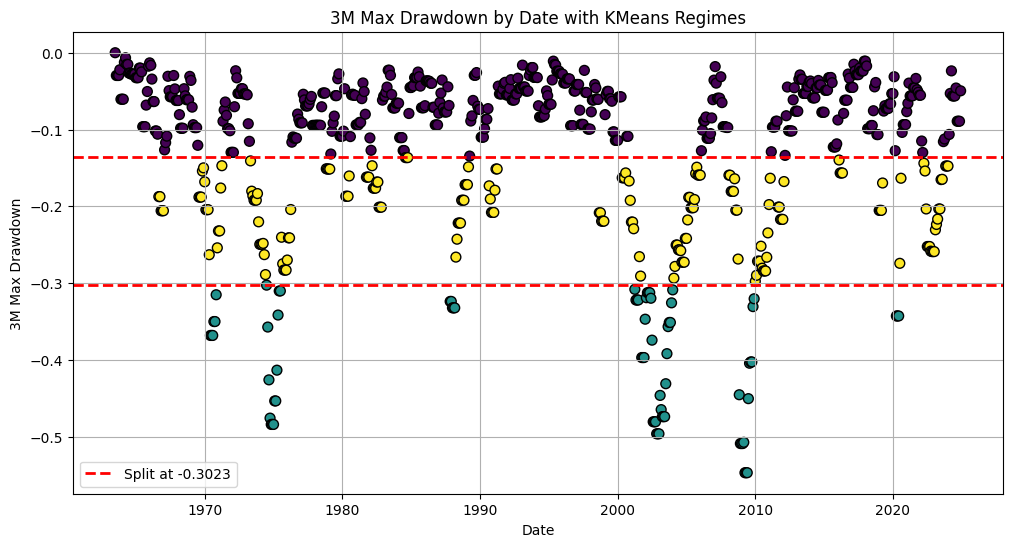

In [169]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
sc = plt.scatter(dd_temp['Date'], dd_temp['3M_Max_Drawdown'],
                 c=dd_temp['DD_cluster'], cmap='viridis', s=50, edgecolors='k')

plt.xlabel('Date')
plt.ylabel('3M Max Drawdown')
plt.title('3M Max Drawdown by Date with KMeans Regimes')
plt.grid(True)

if ML:
    centers = kmeans.cluster_centers_.flatten()

    if cluster_n == 2:
        threshold = np.mean(centers)
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
                    label=f'Regime Split at {threshold:.4f}')
    elif cluster_n > 2:
        centers_sorted = np.sort(centers)
        for i in range(len(centers_sorted) - 1):
            midpoint = (centers_sorted[i] + centers_sorted[i+1]) / 2
            label = f'Split at {midpoint:.4f}' if i == 0 else None
            plt.axhline(y=midpoint, color='red', linestyle='--', linewidth=2, label=label)

plt.legend()
plt.show()


In [170]:

FEATURES = [
    'CPI',
    'Cape',
    'Treasury_10Y',
    'GARCH',
    'Amihud',
    'NFCI'
]

TRUE_REGIME = 'DD_cluster'
DATE = 'Date'

selected_columns =  [DATE] + [TRUE_REGIME] +FEATURES


In [171]:
missing = [col for col in selected_columns if col not in excel_df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

# Subset and drop rows with empty values
input_df = excel_df[selected_columns]
orig_rows = len(input_df)
input_df = input_df.dropna()
print(f"Original rows: {orig_rows}, Dropped rows: {orig_rows - len(input_df)}")
print(f"First obs: {input_df[DATE].min()}, Last obs: {input_df[DATE].max()}")

# Display as neat HTML table (adjust 'rows_to_show' as needed)
rows_to_show = 10
from IPython.display import display, HTML
display(HTML(input_df.head(rows_to_show).to_html(index=False)))

Original rows: 738, Dropped rows: 90
First obs: 1971-01-01 00:00:00, Last obs: 2024-12-01 00:00:00


Date,DD_cluster,CPI,Cape,Treasury_10Y,GARCH,Amihud,NFCI
1971-01-01,2.0,39.8,15.873841,6.24,0.004574,1.053967e-12,0.78118
1971-02-01,2.0,39.9,16.461794,6.11,0.004730,2.828651e-12,0.95666
1971-03-01,2.0,39.9,17.034535,5.70,0.004067,2.046003e-12,1.11851
1971-04-01,2.0,40.0,17.402903,5.83,0.003275,5.897903e-13,1.52025
1971-05-01,0.0,40.1,17.924110,6.39,0.003973,3.574692e-12,1.54573
1971-06-01,0.0,40.3,17.564153,6.52,0.005214,4.786040e-12,1.06164
1971-07-01,0.0,40.5,17.083167,6.73,0.007500,8.377689e-12,1.25745
1971-08-01,0.0,40.6,16.889415,6.58,0.005283,3.696399e-12,2.21678
1971-09-01,0.0,40.7,16.519449,6.14,0.010924,3.785692e-13,2.36252
1971-10-01,0.0,40.8,16.856793,5.93,0.003845,4.525764e-12,1.61771


In [172]:
from tabulate import tabulate

# Calculate the number of observations for each regime in the data
regime_counts = input_df[TRUE_REGIME].value_counts().sort_index().reset_index()
regime_counts.columns = [TRUE_REGIME, 'Count']

print("Number of observations per regime:")
print(tabulate(regime_counts, headers='keys', tablefmt='psql', showindex=False))


Number of observations per regime:
+--------------+---------+
|   DD_cluster |   Count |
|--------------+---------|
|            0 |     412 |
|            1 |      67 |
|            2 |     169 |
+--------------+---------+


In [174]:
if ML_new == True:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, confusion_matrix
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

    # Define predictors and target using the given column lists
    predictors = FEATURES
    target = TRUE_REGIME

    # Drop rows with missing values in predictors or target
    data = input_df.dropna(subset=predictors + [target]).reset_index(drop=True)
    X = data[predictors]
    y = data[target]
    # Also grab the DATE column for printing prediction timestamps
    dates = data[DATE]

    # Flags to indicate whether each model should be included
    include_models = {
        'RandomForest': True,
        'GradientBoosting': False,
        'SVC': False,
        'GaussianNB': True,
        'Logistic': False,
        'LDA': False,
        'QDA': False
    }

    # Toggle for including the meta-learner
    include_meta_learner = False

    # Define the base models with high parameters.
    base_models_all = {
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        'SVC': SVC(probability=True, C=1000, kernel='rbf', gamma='scale'),
        'GaussianNB': GaussianNB(var_smoothing=1e-8),
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis()
    }
    base_models = {name: model for name, model in base_models_all.items() if include_models.get(name, False)}

    # Define the meta-learner
    meta_learner = LogisticRegression(max_iter=1000, random_state=42)

    # Parameters for the training window:
    max_window_size = 84   # The default (maximum) window length
    min_obs = 5           # Minimum number of observations required to make a meta prediction

    # Initialize dictionaries/lists to store rolling accuracies and meta weights
    rolling_accuracies_base = {name: [] for name in base_models}
    rolling_accuracies_meta = []
    meta_weights_list = []  # record meta-learner coefficients

    # Initialize expanding meta training set (meta features and outcomes)
    meta_train_features = []
    meta_train_targets = []

    # Initialize lists to store predictions for all models
    predicted_dates_all = []  # Collect all test dates (i >=1)
    predicted_base = {name: [] for name in base_models}  # To collect base model predictions
    predicted_meta = []  # To collect meta predictions (NaN when not available)

    print("Starting rolling window evaluation with stacking ensemble and expanding meta learner:")

    for i in range(len(X)):
        # For the first observation, we have no training window so we skip meta feature generation.
        if i == 0:
            print(f"Skipping first observation at {dates.iloc[i]} (no training data available).")
            continue

        test_date = dates.iloc[i]
        predicted_dates_all.append(test_date)

        # Build the default training window: if we haven't reached max_window_size yet, use all available data.
        if i < max_window_size:
            X_train_window = X.iloc[:i]
            y_train_window = y.iloc[:i]
        else:
            X_train_window = X.iloc[i - max_window_size:i]
            y_train_window = y.iloc[i - max_window_size:i]

        # If, for any reason, the training set is smaller than min_obs, expand the window.
        if len(X_train_window) < min_obs:
            additional_needed = min_obs - len(X_train_window)
            new_start = max(0, i - max_window_size - additional_needed)
            X_train_window = X.iloc[new_start:i]
            y_train_window = y.iloc[new_start:i]
            print(f"Expanding training window for timestamp {test_date} to {len(X_train_window)} obs (expanded from default {max_window_size}).")

        X_test_window = X.iloc[[i]]
        y_test_window = y.iloc[[i]]

        # --- Step 1: Generate meta features from base model predictions ---
        # Check if training window has at least 2 classes
        if len(np.unique(y_train_window)) < 2:
            unique_class = np.unique(y_train_window)[0]
            for name in base_models:
                predicted_base[name].append(unique_class)
            default_prob = 1.0 if unique_class == 1 else 0.0
            meta_features_test = np.full((1, len(base_models)), default_prob)
            for name in base_models.keys():
                acc = accuracy_score(y_test_window, [unique_class])
                rolling_accuracies_base[name].append(acc)
            print(f"Test date {test_date}: Training window has only one class ({unique_class}). Using default predictions.")
        else:
            meta_features_test = np.zeros((1, len(base_models)))
            for j, (name, model) in enumerate(base_models.items()):
                try:
                    model.fit(X_train_window, y_train_window)
                    y_pred = model.predict(X_test_window)[0]
                    predicted_base[name].append(y_pred)
                    probs = model.predict_proba(X_test_window)
                    if probs.shape[1] == 1:
                        y_pred_prob = 1.0 if model.classes_[0] == 1 else 0.0
                    else:
                        y_pred_prob = probs[0, 1]
                    meta_features_test[0, j] = y_pred_prob
                    acc = accuracy_score(y_test_window, [y_pred])
                except ValueError as e:
                    print(f"Model {name} failed to fit: {e}. Using default prediction.")
                    majority_class = pd.Series(y_train_window).mode()[0]
                    y_pred = majority_class
                    predicted_base[name].append(y_pred)
                    y_pred_prob = 1.0 if majority_class == 1 else 0.0
                    meta_features_test[0, j] = y_pred_prob
                    acc = accuracy_score(y_test_window, [y_pred])
                rolling_accuracies_base[name].append(acc)

        # --- Step 2: Use meta training set to make meta prediction if enabled and we have enough data ---
        meta_pred = np.nan
        if include_meta_learner:
            if i >= min_obs and len(np.unique(meta_train_targets)) > 1:
                meta_learner.fit(np.array(meta_train_features), np.array(meta_train_targets))
                meta_pred = meta_learner.predict(meta_features_test)[0]
                meta_acc = accuracy_score(y_test_window, [meta_pred])
                rolling_accuracies_meta.append(meta_acc)
                meta_weights_list.append(meta_learner.coef_[0])
                print(f"Test date {test_date}: Meta Learner Prediction = {meta_pred}, Accuracy = {meta_acc:.2f}")
            else:
                print(f"Test date {test_date}: Base Model predictions only (growing training window).")
        else:
            print(f"Test date {test_date}: Meta Learner disabled, using base model predictions only.")
        predicted_meta.append(meta_pred)

        # --- Step 3: Append current meta features and true outcome to the expanding meta training set ---
        meta_train_features.append(meta_features_test[0])
        meta_train_targets.append(y_test_window.iloc[0])

    # --- Aggregation of Results ---
    avg_base_acc = {name: np.mean(acc_list) if acc_list else 0 for name, acc_list in rolling_accuracies_base.items()}
    avg_meta_acc = np.mean(rolling_accuracies_meta) if rolling_accuracies_meta else 0
    avg_meta_weights = np.mean(meta_weights_list, axis=0) if meta_weights_list else np.array([])

    results_table = pd.DataFrame({
        'Model': list(avg_base_acc.keys()) + ['Meta Learner'],
        'Average Accuracy': list(avg_base_acc.values()) + [avg_meta_acc]
    })
    print("\nRolling Window Average Accuracies:")
    print(results_table)

    if include_meta_learner and avg_meta_weights.size > 0:
        weights_table = pd.DataFrame({
            'Base Model': list(base_models.keys()),
            'Average Weight': avg_meta_weights
        })
        print("\nAggregate Meta-Learner Weights (Average Coefficients):")
        print(weights_table)

    # Create predictions DataFrame with all models
    predictions_df = pd.DataFrame({'Date': predicted_dates_all})
    for name in base_models:
        predictions_df[name] = predicted_base[name]
    predictions_df['Meta'] = predicted_meta


Starting rolling window evaluation with stacking ensemble and expanding meta learner:
Skipping first observation at 1971-01-01 00:00:00 (no training data available).
Expanding training window for timestamp 1971-02-01 00:00:00 to 1 obs (expanded from default 84).
Test date 1971-02-01 00:00:00: Training window has only one class (2.0). Using default predictions.
Test date 1971-02-01 00:00:00: Meta Learner disabled, using base model predictions only.
Expanding training window for timestamp 1971-03-01 00:00:00 to 2 obs (expanded from default 84).
Test date 1971-03-01 00:00:00: Training window has only one class (2.0). Using default predictions.
Test date 1971-03-01 00:00:00: Meta Learner disabled, using base model predictions only.
Expanding training window for timestamp 1971-04-01 00:00:00 to 3 obs (expanded from default 84).
Test date 1971-04-01 00:00:00: Training window has only one class (2.0). Using default predictions.
Test date 1971-04-01 00:00:00: Meta Learner disabled, using base 

In [180]:
# New Cell: Display regime-specific performance and confusion matrix for Random Forest
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import display, HTML

# Merge predictions with the true labels using an inner join so that only dates with predictions are included
true_labels_df = data[[DATE, target]].rename(columns={DATE: 'Date', target: 'True_reg'})
merged_df = pd.merge(predictions_df, true_labels_df, on='Date', how='inner')

# Warn if some observations were skipped
num_skipped = len(data) - len(merged_df)
if num_skipped > 0:
    print(f"Warning: {num_skipped} observations were skipped due to missing predictions.\n")

total_obs = len(merged_df)

# Compute overall accuracy for Random Forest
rf_overall_accuracy = accuracy_score(merged_df['True_reg'], merged_df['RandomForest'])
print(f"Random Forest Overall Accuracy: {rf_overall_accuracy:.2f}\n")

# Compute counts per regime for true and predicted values
true_counts = merged_df['True_reg'].value_counts().sort_index()
pred_counts = merged_df['RandomForest'].value_counts().sort_index()

# Use the union of regimes from true labels and predictions
regime_list = sorted(set(merged_df['True_reg'].unique()).union(set(merged_df['RandomForest'].unique())))

results_rf = []
for regime in regime_list:
    # Subset where the actual regime equals the current regime for regime-specific accuracy.
    subset = merged_df[merged_df['True_reg'] == regime]
    # Accuracy computed only on the observations with this true regime
    acc = accuracy_score(subset['True_reg'], subset['RandomForest']) if len(subset) > 0 else None
    total_n = true_counts.get(regime, 0)
    # Predicted count is computed over all predictions
    predicted_n = pred_counts.get(regime, 0)
    actual_pct = (total_n / total_obs * 100) if total_obs > 0 else 0
    predicted_pct = (predicted_n / total_obs * 100) if total_obs > 0 else 0

    results_rf.append({
        'Regime': regime,
        'Accuracy': f"{acc:.2f}" if acc is not None else "N/A",
        'Total N': total_n,
        'Actual %': f"{actual_pct:.2f}%",
        'Predicted N': predicted_n,
        'Predicted %': f"{predicted_pct:.2f}%"
    })

results_rf_df = pd.DataFrame(results_rf)

# Display regime performance as an HTML table
print("Random Forest Regime-specific performance:")
display(HTML(results_rf_df.to_html(index=False, justify='center')))

# Create the confusion matrix
cm_rf = confusion_matrix(merged_df['True_reg'], merged_df['RandomForest'], labels=regime_list)
cm_rf_df = pd.DataFrame(cm_rf, index=[f"True {lab}" for lab in regime_list],
                        columns=[f"Pred {lab}" for lab in regime_list])

# Display confusion matrix as an HTML table
print("Random Forest Confusion Matrix:")
display(HTML(cm_rf_df.to_html(justify='center')))



Random Forest Overall Accuracy: 0.86

Random Forest Regime-specific performance:


Regime,Accuracy,Total N,Actual %,Predicted N,Predicted %
0.0,0.92,412,63.68%,425,65.69%
1.0,0.81,67,10.36%,65,10.05%
2.0,0.71,168,25.97%,157,24.27%


Random Forest Confusion Matrix:


,Pred 0.0,Pred 1.0,Pred 2.0
True 0.0,381,0,31
True 1.0,7,54,6
True 2.0,37,11,120


<ipython-input-181-b87e26b6782e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


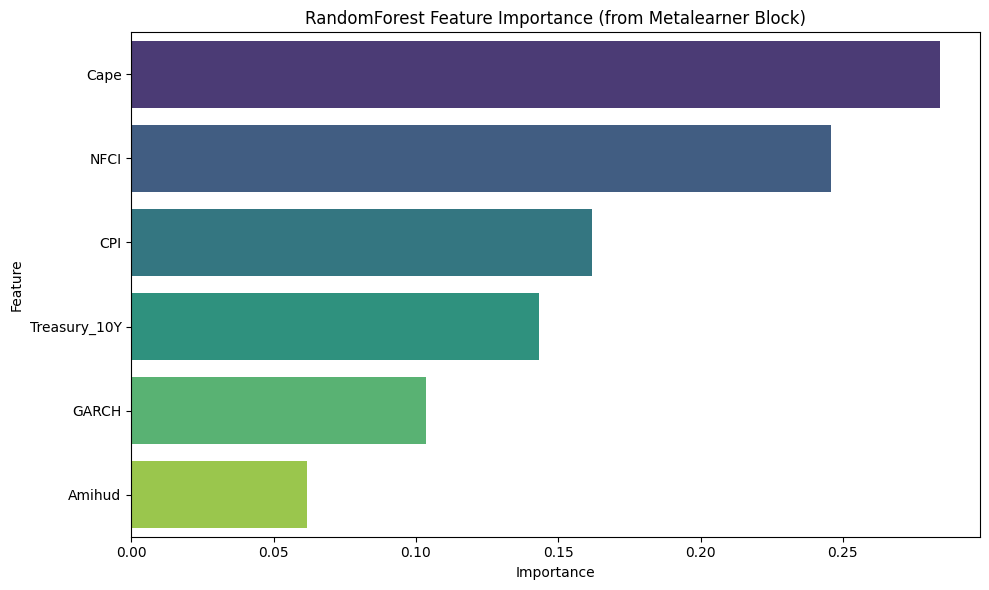

In [181]:
# New Cell: Plot Feature Importances from the RandomForest used in the ensemble

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Retrieve the RandomForest model from the base models dictionary
rf_model = base_models['RandomForest']

# Check if the RandomForest model has the feature_importances_ attribute
if hasattr(rf_model, 'feature_importances_'):
    # Get the feature importances from the model (from its last training iteration)
    rf_importances = rf_model.feature_importances_

    # Create a DataFrame for easy plotting
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot the feature importances using a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title("RandomForest Feature Importance (from Metalearner Block)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("The RandomForest model does not expose feature importances.")


In [182]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Read the Excel file and parse the target sheet "22.2.2025"
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
excel_df = xls_file.parse("22.2.2025")

# Ensure the Date column is in datetime format
excel_df['Date'] = pd.to_datetime(excel_df['Date'])

# Merge the Random Forest predictions into the original DataFrame on the Date column
merged_df = excel_df.merge(predictions_df[['Date', 'RandomForest']], on='Date', how='left')

# Sort the DataFrame by Date (optional)
merged_df = merged_df.sort_values('Date').reset_index(drop=True)

# Create a new workbook and set the active sheet title to "data"
new_wb = Workbook()
ws = new_wb.active
ws.title = "data"

# Write the merged DataFrame to the new sheet
for r in dataframe_to_rows(merged_df, index=False, header=True):
    ws.append(r)

# Save the new workbook
new_wb.save("data+regimes.xlsx")


In [ ]:
if ML_old == True:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, confusion_matrix

    # Define predictors and target using the given column lists
    predictors = FEATURES
    target = TRUE_REGIME

    # Drop rows with missing values in predictors or target
    data = input_df.dropna(subset=predictors + [target]).reset_index(drop=True)
    X = data[predictors]
    y = data[target]
    # Also grab the DATE column for printing prediction timestamps
    dates = data[DATE]

    # Flags to indicate whether each model should be included
    include_models = {
        'RandomForest': True,
        'GradientBoosting': False,
        'SVC': False,
        'GaussianNB': True
    }

    # Define the base models with high parameters.
    # Only include the model if its flag is True.
    base_models_all = {
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        'SVC': SVC(probability=True, C=1000, kernel='rbf', gamma='scale'),
        'GaussianNB': GaussianNB(var_smoothing=1e-8)
    }
    base_models = {name: model for name, model in base_models_all.items() if include_models.get(name, False)}

    # Define the meta-learner
    meta_learner = LogisticRegression(max_iter=1000, random_state=42)

    # Parameters for the training window:
    max_window_size = 84   # The default (maximum) window length
    min_obs = 84           # Minimum number of observations required to make a prediction

    # Initialize dictionaries/lists to store rolling accuracies and meta weights
    rolling_accuracies_base = {name: [] for name in base_models}
    rolling_accuracies_meta = []
    meta_weights_list = []  # record meta-learner coefficients

    # Initialize expanding meta training set (meta features and outcomes)
    meta_train_features = []
    meta_train_targets = []

    # Initialize lists to store predictions for later use (for merging with Excel)
    predicted_dates = []
    predicted_regs = []

    print("Starting rolling window evaluation with stacking ensemble and expanding meta learner:")

    for i in range(len(X)):
        # Skip prediction if overall available observations are less than the minimum required
        if i < min_obs:
            print(f"Skipping prediction for timestamp {dates.iloc[i]} (insufficient overall data: {i} obs, need at least {min_obs}).")
            continue

        # Build the default training window: if we haven't reached max_window_size yet, use all available data.
        if i < max_window_size:
            X_train_window = X.iloc[:i]
            y_train_window = y.iloc[:i]
        else:
            X_train_window = X.iloc[i - max_window_size:i]
            y_train_window = y.iloc[i - max_window_size:i]

        # If, for any reason (e.g. after filtering in a regime split scenario), the training set is smaller than min_obs,
        # attempt to expand the training window further back.
        if len(X_train_window) < min_obs:
            additional_needed = min_obs - len(X_train_window)
            new_start = max(0, i - max_window_size - additional_needed)
            X_train_window = X.iloc[new_start:i]
            y_train_window = y.iloc[new_start:i]
            print(f"Expanding training window for timestamp {dates.iloc[i]} to {len(X_train_window)} obs (expanded from default {max_window_size}).")
        # Get the training window date range for printing
        train_start_date = dates.iloc[X_train_window.index[0]]
        train_end_date = dates.iloc[X_train_window.index[-1]]

        X_test_window = X.iloc[[i]]
        y_test_window = y.iloc[[i]]
        test_date = dates.iloc[i]

        # --- Step 1: Generate meta features from base model predictions ---
        meta_features_test = np.zeros((1, len(base_models)))
        for j, (name, model) in enumerate(base_models.items()):
            model.fit(X_train_window, y_train_window)
            probs = model.predict_proba(X_test_window)
            if probs.shape[1] == 1:
                # Edge-case: model returns only one class probability
                y_pred_prob = 1.0 if model.classes_[0] == 1 else 0.0
            else:
                y_pred_prob = probs[0, 1]
            meta_features_test[0, j] = y_pred_prob

            # Record accuracy for each base model on this test observation
            y_pred = model.predict(X_test_window)[0]
            acc = accuracy_score(y_test_window, [y_pred])
            rolling_accuracies_base[name].append(acc)

        # --- Step 2: Use meta training set to make meta prediction as soon as available ---
# --- Step 2: Use meta training set to make meta prediction as soon as available ---
            if len(meta_train_features) > 0 and len(np.unique(meta_train_targets)) > 1:
                meta_learner.fit(np.array(meta_train_features), np.array(meta_train_targets))
                meta_pred = meta_learner.predict(meta_features_test)[0]
                meta_acc = accuracy_score(y_test_window, [meta_pred])
                rolling_accuracies_meta.append(meta_acc)
                meta_weights_list.append(meta_learner.coef_[0])
                print(f"Test date {test_date}: Meta Learner Prediction = {meta_pred}, Accuracy = {meta_acc:.2f}. Training window: {train_start_date} to {train_end_date}")
                predicted_dates.append(test_date)
                predicted_regs.append(meta_pred)
            else:
                print(f"Test date {test_date}: Meta learner not trained (only one class in meta training set). Using base model predictions only. Training window: {train_start_date} to {train_end_date}")

        # --- Step 3: Append current meta features and true outcome to the expanding meta training set ---
        meta_train_features.append(meta_features_test[0])
        meta_train_targets.append(y_test_window.iloc[0])

    # --- Aggregation of Results ---
    avg_base_acc = {name: np.mean(acc_list) if acc_list else 0 for name, acc_list in rolling_accuracies_base.items()}
    avg_meta_acc = np.mean(rolling_accuracies_meta) if rolling_accuracies_meta else 0
    avg_meta_weights = np.mean(meta_weights_list, axis=0) if meta_weights_list else np.array([])

    results_table = pd.DataFrame({
        'Model': list(avg_base_acc.keys()) + ['Meta Learner'],
        'Average Accuracy': list(avg_base_acc.values()) + [avg_meta_acc]
    })
    print("\nRolling Window Average Accuracies:")
    print(results_table)

    if avg_meta_weights.size > 0:
        weights_table = pd.DataFrame({
            'Base Model': list(base_models.keys()),
            'Average Weight': avg_meta_weights
        })
        print("\nAggregate Meta-Learner Weights (Average Coefficients):")
        print(weights_table)

# --- Excel Merge Block ---
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Ensure that predicted_dates and predicted_regs exist in your workspace
if 'predicted_dates' not in globals() or 'predicted_regs' not in globals():
    raise NameError("predicted_dates and/or predicted_regs not found. Please ensure these variables exist before running this cell.")

# Create a DataFrame with the prediction data.
predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted_reg': predicted_regs
})


In [ ]:
if ML == True:

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.linear_model import LogisticRegression
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, confusion_matrix

    # Define predictors and target using the given column lists.
    # Here, it is assumed that FEATURES contains only one feature (e.g. GARCH predicted volatility).
    predictors = FEATURES
    target = TRUE_REGIME

    # Drop rows with missing values in predictors or target
    data = input_df.dropna(subset=predictors + [target]).reset_index(drop=True)
    X = data[predictors]
    y = data[target]
    # Also grab the DATE column for printing prediction timestamps
    dates = data[DATE]

    # Define the base models suited for one feature.
    base_models = {
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'KNN': KNeighborsClassifier(),
        'LinearSVC': SVC(probability=True, kernel='linear', random_state=42)
    }

    # Define the meta-learner (using logistic regression here)
    meta_learner = LogisticRegression(max_iter=1000, random_state=42)

    window_size = 60  # fixed window length once reached
    min_data_pct = 0.8  # start base model predictions when available data >= 80% of window_size
    base_threshold = int(window_size * min_data_pct)

    # Minimum number of meta training samples required before using the meta learner.
    meta_threshold = 10

    # Initialize dictionaries/lists to store rolling accuracies and meta weights
    rolling_accuracies_base = {name: [] for name in base_models}
    rolling_accuracies_meta = []
    meta_weights_list = []  # record meta-learner coefficients

    # Initialize expanding meta training set (meta features and outcomes)
    meta_train_features = []
    meta_train_targets = []

    print("Starting rolling window evaluation with stacking ensemble (single feature models) and meta learner:")

    for i in range(len(X)):
        # Do not make any prediction until we have at least base_threshold observations
        if i < base_threshold:
            print(f"Skipping prediction for timestamp {dates.iloc[i]} "
                  f"(insufficient data: {i} observations, need {base_threshold}).")
            continue

        # For base models, if i is less than full window_size, use all data from start to i.
        # Once i >= window_size, use a fixed rolling window of size window_size.
        if i < window_size:
            X_train_window = X.iloc[:i]
            y_train_window = y.iloc[:i]
        else:
            X_train_window = X.iloc[i-window_size:i]
            y_train_window = y.iloc[i-window_size:i]

        X_test_window = X.iloc[[i]]
        y_test_window = y.iloc[[i]]
        test_date = dates.iloc[i]

        # --- Step 1: Generate meta features from base model predictions ---
        meta_features_test = np.zeros((1, len(base_models)))
        for j, (name, model) in enumerate(base_models.items()):
            try:
                model.fit(X_train_window, y_train_window)
                probs = model.predict_proba(X_test_window)
                if probs.shape[1] == 1:
                    # Edge-case: model returns only one class probability
                    y_pred_prob = 1.0 if model.classes_[0] == 1 else 0.0
                else:
                    y_pred_prob = probs[0, 1]
            except ValueError as e:
                # If the model fails (for example, insufficient samples in one class), use a default probability.
                print(f"Warning: {e} for model {name} at {test_date}. Using default probability 0.5.")
                y_pred_prob = 0.5

            meta_features_test[0, j] = y_pred_prob

            # Record accuracy for each base model on this test observation.
            try:
                y_pred = model.predict(X_test_window)[0]
            except Exception:
                y_pred = np.nan  # in case prediction fails
            acc = accuracy_score(y_test_window, [y_pred])
            rolling_accuracies_base[name].append(acc)

        # --- Step 2: Use meta training set to make meta prediction once sufficient meta data is available ---
        if i >= window_size and len(meta_train_features) >= meta_threshold:
            meta_learner.fit(np.array(meta_train_features), np.array(meta_train_targets))
            meta_pred = meta_learner.predict(meta_features_test)[0]
            meta_acc = accuracy_score(y_test_window, [meta_pred])
            rolling_accuracies_meta.append(meta_acc)
            meta_weights_list.append(meta_learner.coef_[0])
            prediction_source = "Meta Learner"
            print(f"Test date {test_date}: {prediction_source} Prediction = {meta_pred}, Accuracy = {meta_acc:.2f}")
        else:
            print(f"Test date {test_date}: Base Model predictions only (growing meta training set).")

        # --- Step 3: Append current meta features and true outcome to the expanding meta training set ---
        meta_train_features.append(meta_features_test[0])
        meta_train_targets.append(y_test_window.iloc[0])

    # --- Aggregation of Results ---
    avg_base_acc = {name: np.mean(acc_list) if acc_list else 0 for name, acc_list in rolling_accuracies_base.items()}
    avg_meta_acc = np.mean(rolling_accuracies_meta) if rolling_accuracies_meta else 0
    avg_meta_weights = np.mean(meta_weights_list, axis=0) if meta_weights_list else np.array([])

    results_table = pd.DataFrame({
        'Model': list(avg_base_acc.keys()) + ['Meta Learner'],
        'Average Accuracy': list(avg_base_acc.values()) + [avg_meta_acc]
    })
    print("\nRolling Window Average Accuracies:")
    print(results_table)

    if avg_meta_weights.size > 0:
        weights_table = pd.DataFrame({
            'Base Model': list(base_models.keys()),
            'Average Weight': avg_meta_weights
        })
        print("\nAggregate Meta-Learner Weights (Average Coefficients):")
        print(weights_table)


In [ ]:
if DL == True:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    import xgboost as xgb
    from sklearn.metrics import confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Parameters:
    training_window = 120  # Use the previous 120 months as training data
    seq_len = 60           # Generate overlapping sequences of 60 months within the training window
    num_classes = cluster_n  # Regimes are assumed to be labeled 0, 1, 2
    num_features = len(FEATURES)

    all_preds = []   # To store predictions
    all_true = []    # To store true regime labels
    dates_list = []  # To store corresponding dates

    # Ensure data is sorted by date
    data = input_df.sort_values(DATE).reset_index(drop=True)

    # Rolling window: start at index = training_window until end of data
    for i in range(training_window, len(data)):
        # Use the previous 120 months as the training window
        train_window = data.iloc[i - training_window:i].reset_index(drop=True)
        if len(train_window) < training_window:
            continue

        # Generate overlapping sequences of length 60 within the training window
        X_train_sequences = []
        y_train = []
        for j in range(len(train_window) - seq_len + 1):
            seq = train_window[FEATURES].iloc[j : j + seq_len].values
            target = train_window[TRUE_REGIME].iloc[j + seq_len - 1]  # target is the regime at the end of the sequence
            X_train_sequences.append(seq)
            y_train.append(target)
        X_train_sequences = np.array(X_train_sequences)  # shape: (num_samples, seq_len, num_features)
        y_train = np.array(y_train)

        # Build an LSTM feature extractor model using an Input layer
        input_layer = Input(shape=(seq_len, num_features))
        lstm_out = LSTM(32, return_sequences=False)(input_layer)
        dropout_out = Dropout(0.2)(lstm_out)
        feature_extractor = Model(inputs=input_layer, outputs=dropout_out)

        # Extract features from the training sequences
        X_train_features = feature_extractor.predict(X_train_sequences, verbose=0)

        # Train an XGBoost classifier on these features.
        clf = xgb.XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='mlogloss')
        clf.fit(X_train_features, y_train)

        # For prediction, use the last 60-month sequence in the training window
        X_pred_seq = train_window[FEATURES].iloc[-seq_len:].values.reshape(1, seq_len, num_features)
        X_pred_feature = feature_extractor.predict(X_pred_seq, verbose=0)
        pred_regime = clf.predict(X_pred_feature)[0]

        # The true regime for the next month (time index i)
        true_regime = data[TRUE_REGIME].iloc[i]

        all_preds.append(pred_regime)
        all_true.append(true_regime)
        dates_list.append(data[DATE].iloc[i])

        print(f"Prediction for {data[DATE].iloc[i]}: Predicted={pred_regime}, True={true_regime}")

    # Compute overall accuracy
    accuracy = accuracy_score(all_true, all_preds)
    print(f"\nOverall Accuracy: {accuracy*100:.2f}%")

    # Create and visualize the confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Rolling Window Hybrid (LSTM + XGBoost) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Read the Excel file and parse the target sheet "22.2.2025"
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
excel_df = xls_file.parse("22.2.2025")

# Ensure the Date column is in datetime format
excel_df['Date'] = pd.to_datetime(excel_df['Date'])

# Merge the predictions into the original DataFrame on the Date column
merged_df = excel_df.merge(predictions_df, on='Date', how='left')

# Sort the DataFrame by Date (optional)
merged_df = merged_df.sort_values('Date').reset_index(drop=True)

# Create a new workbook and set the active sheet title to "data"
new_wb = Workbook()
ws = new_wb.active
ws.title = "data"

# Write the merged DataFrame to the new sheet
for r in dataframe_to_rows(merged_df, index=False, header=True):
    ws.append(r)

# Save the new workbook
new_wb.save("data+regimes.xlsx")
